### 1. Import

In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from agent import Agent, img_stack
import time
from collections import deque
import matplotlib
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

seed = 0 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

action_repeat = 10
env = gym.make('CarRacing-v0', verbose=0)
state = env.reset()
print('env.action_space.shape: ', env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print('reward_threshold', reward_threshold)

device:  cuda
env.action_space.shape:  (3,)
reward_threshold 900


### 2. Image Preprocessing

frame.shape:  (96, 96, 3)
img.shape:  (96, 96)


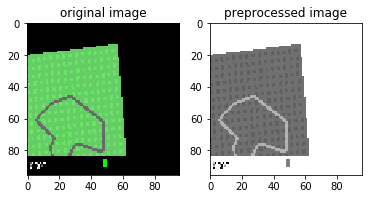

In [2]:
# show what a preprocessed image looks like
frame, _, _, _ = env.step(np.array([2., 1., 1.]))

print('frame.shape: ', frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

#-------------------------------#

def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
    gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    if norm:
        # normalize
        gray = gray / 128. - 1.
    return gray

img_gray = rgb2gray(frame)

#-------------------------------# 
plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

### 2. Class  Wrapper

In [6]:
class Wrapper():
    """
    Environment wrapper for CarRacing 
    """

    def __init__(self, env):
        self.env = env  

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = env.reset()
        img_gray = rgb2gray(img_rgb)
        self.stack = [img_gray] * img_stack  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(action_repeat):
            img_rgb, reward, die, _ = env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == img_stack
        return np.array(self.stack), total_reward, done, die


    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [7]:
def save(agent, directory, filename, suffix):
    torch.save(agent.net.state_dict(), '%s/%s_%s.pth' % (directory, filename, suffix))    

### 2. Train Agent

In [9]:
agent = Agent(device)

env_wrap = Wrapper(env)

limits = [200, 400, 600, 800, 830, 870, 900]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf           


def ppo_train(n_episodes=5000, save_every=500):
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    timestep_after_last_save = 0
    
    time_start = time.time()

    running_score = 0
    state = env_wrap.reset()
    
    i_lim = 0
    
    for i_episode in range(n_episodes):
        
        timestep = 0
        total_reward = 0
        
        ## score = 0
        state = env_wrap.reset()

        while True:    
            
            action, a_logp = agent.select_action(state)
            next_state, reward, done, die = env_wrap.step( 
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()
            
            total_reward += reward
            state = next_state
            
            timestep += 1  
            timestep_after_last_save += 1
            
            if done or die:
                break
                
        running_score = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        s = (int)(time.time() - time_start)        
        print('Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score {:.2f}, \
Time: {:02}:{:02}:{:02} '\
            .format(i_episode, timestep, \
                    total_reward, avg_score, running_score, s//3600, s%3600//60, s%60))  
       
        
        # Save episode if more than save_every=500 timesteps
        if timestep_after_last_save >= save_every:

            timestep_after_last_save %= save_every            
            suf = return_suffix(avg_score)
            save(agent, 'dir_chk', 'model_weights', suf)
            
        if np.mean(scores_deque) > reward_threshold:
            print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !" \
                  .format(running_score, avg_score))
            break
            
    return scores_array, avg_scores_array    
            
scores, avg_scores  = ppo_train()            

Ep. 0, Ep.Timesteps 100, Score: 94.08, Avg.Score: 94.08, Run.Score 0.94, Time: 00:00:10 
Ep. 1, Ep.Timesteps 92, Score: -18.03, Avg.Score: 38.02, Run.Score 0.75, Time: 00:00:19 
Ep. 2, Ep.Timesteps 84, Score: -11.72, Avg.Score: 21.44, Run.Score 0.63, Time: 00:00:27 
Ep. 3, Ep.Timesteps 100, Score: 78.95, Avg.Score: 35.82, Run.Score 1.41, Time: 00:00:40 
Ep. 4, Ep.Timesteps 91, Score: -18.05, Avg.Score: 25.04, Run.Score 1.21, Time: 00:00:49 
Ep. 5, Ep.Timesteps 91, Score: -17.97, Avg.Score: 17.88, Run.Score 1.02, Time: 00:00:58 
Ep. 6, Ep.Timesteps 86, Score: -17.90, Avg.Score: 12.76, Run.Score 0.83, Time: 00:01:07 
Ep. 7, Ep.Timesteps 90, Score: -16.57, Avg.Score: 9.10, Run.Score 0.66, Time: 00:01:16 
Ep. 8, Ep.Timesteps 88, Score: -17.99, Avg.Score: 6.09, Run.Score 0.47, Time: 00:01:25 
Ep. 9, Ep.Timesteps 77, Score: -18.06, Avg.Score: 3.67, Run.Score 0.29, Time: 00:01:33 
Ep. 10, Ep.Timesteps 87, Score: -17.92, Avg.Score: 1.71, Run.Score 0.11, Time: 00:01:44 
Ep. 11, Ep.Timesteps 81,

Ep. 92, Ep.Timesteps 89, Score: -16.72, Avg.Score: 12.09, Run.Score 7.24, Time: 00:14:31 
Ep. 93, Ep.Timesteps 56, Score: -17.93, Avg.Score: 11.77, Run.Score 6.99, Time: 00:14:38 
Ep. 94, Ep.Timesteps 100, Score: -17.92, Avg.Score: 11.46, Run.Score 6.74, Time: 00:14:47 
Ep. 95, Ep.Timesteps 100, Score: 111.86, Avg.Score: 12.50, Run.Score 7.79, Time: 00:14:59 
Ep. 96, Ep.Timesteps 100, Score: 108.30, Avg.Score: 13.49, Run.Score 8.79, Time: 00:15:09 
Ep. 97, Ep.Timesteps 100, Score: 87.95, Avg.Score: 14.25, Run.Score 9.59, Time: 00:15:19 
Ep. 98, Ep.Timesteps 25, Score: 15.10, Avg.Score: 14.26, Run.Score 9.64, Time: 00:15:21 
Ep. 99, Ep.Timesteps 63, Score: -18.03, Avg.Score: 13.94, Run.Score 9.36, Time: 00:15:27 
Ep. 100, Ep.Timesteps 100, Score: 114.70, Avg.Score: 14.14, Run.Score 10.42, Time: 00:15:36 
Ep. 101, Ep.Timesteps 64, Score: 13.34, Avg.Score: 14.46, Run.Score 10.45, Time: 00:15:42 
Ep. 102, Ep.Timesteps 89, Score: -17.83, Avg.Score: 14.40, Run.Score 10.16, Time: 00:15:51 
Ep

Ep. 183, Ep.Timesteps 54, Score: 13.78, Avg.Score: 8.24, Run.Score 6.56, Time: 00:26:53 
Ep. 184, Ep.Timesteps 35, Score: 13.12, Avg.Score: 8.56, Run.Score 6.63, Time: 00:26:56 
Ep. 185, Ep.Timesteps 75, Score: 30.65, Avg.Score: 9.05, Run.Score 6.87, Time: 00:27:04 
Ep. 186, Ep.Timesteps 70, Score: 9.15, Avg.Score: 9.01, Run.Score 6.89, Time: 00:27:11 
Ep. 187, Ep.Timesteps 54, Score: 12.87, Avg.Score: 9.05, Run.Score 6.95, Time: 00:27:17 
Ep. 188, Ep.Timesteps 74, Score: -18.07, Avg.Score: 8.04, Run.Score 6.70, Time: 00:27:25 
Ep. 189, Ep.Timesteps 63, Score: -18.08, Avg.Score: 7.80, Run.Score 6.45, Time: 00:27:31 
Ep. 190, Ep.Timesteps 87, Score: 38.50, Avg.Score: 8.29, Run.Score 6.77, Time: 00:27:39 
Ep. 191, Ep.Timesteps 63, Score: 14.12, Avg.Score: 7.37, Run.Score 6.85, Time: 00:27:45 
Ep. 192, Ep.Timesteps 49, Score: 18.24, Avg.Score: 7.72, Run.Score 6.96, Time: 00:27:50 
Ep. 193, Ep.Timesteps 93, Score: 26.18, Avg.Score: 8.16, Run.Score 7.15, Time: 00:27:59 
Ep. 194, Ep.Timestep

Ep. 275, Ep.Timesteps 71, Score: 23.41, Avg.Score: 13.69, Run.Score 11.28, Time: 00:36:47 
Ep. 276, Ep.Timesteps 71, Score: 10.28, Avg.Score: 13.78, Run.Score 11.27, Time: 00:36:53 
Ep. 277, Ep.Timesteps 59, Score: -18.06, Avg.Score: 13.78, Run.Score 10.97, Time: 00:36:59 
Ep. 278, Ep.Timesteps 65, Score: -1.56, Avg.Score: 13.65, Run.Score 10.85, Time: 00:37:05 
Ep. 279, Ep.Timesteps 30, Score: 8.76, Avg.Score: 13.57, Run.Score 10.83, Time: 00:37:08 
Ep. 280, Ep.Timesteps 70, Score: 34.83, Avg.Score: 13.47, Run.Score 11.07, Time: 00:37:14 
Ep. 281, Ep.Timesteps 77, Score: 34.71, Avg.Score: 13.99, Run.Score 11.31, Time: 00:37:21 
Ep. 282, Ep.Timesteps 54, Score: 22.16, Avg.Score: 13.99, Run.Score 11.41, Time: 00:37:26 
Ep. 283, Ep.Timesteps 25, Score: 9.03, Avg.Score: 13.94, Run.Score 11.39, Time: 00:37:29 
Ep. 284, Ep.Timesteps 33, Score: 13.25, Avg.Score: 13.94, Run.Score 11.41, Time: 00:37:32 
Ep. 285, Ep.Timesteps 72, Score: 24.29, Avg.Score: 13.88, Run.Score 11.54, Time: 00:37:39 


Ep. 365, Ep.Timesteps 55, Score: 24.47, Avg.Score: 13.08, Run.Score 12.89, Time: 00:44:28 
Ep. 366, Ep.Timesteps 45, Score: 21.70, Avg.Score: 13.48, Run.Score 12.98, Time: 00:44:33 
Ep. 367, Ep.Timesteps 36, Score: 13.80, Avg.Score: 13.52, Run.Score 12.98, Time: 00:44:36 
Ep. 368, Ep.Timesteps 47, Score: 23.71, Avg.Score: 13.94, Run.Score 13.09, Time: 00:44:41 
Ep. 369, Ep.Timesteps 56, Score: 18.52, Avg.Score: 14.02, Run.Score 13.15, Time: 00:44:46 
Ep. 370, Ep.Timesteps 58, Score: 17.03, Avg.Score: 13.93, Run.Score 13.18, Time: 00:44:52 
Ep. 371, Ep.Timesteps 77, Score: 56.02, Avg.Score: 14.34, Run.Score 13.61, Time: 00:44:59 
Ep. 372, Ep.Timesteps 36, Score: 9.17, Avg.Score: 14.24, Run.Score 13.57, Time: 00:45:03 
Ep. 373, Ep.Timesteps 28, Score: 13.86, Avg.Score: 14.28, Run.Score 13.57, Time: 00:45:05 
Ep. 374, Ep.Timesteps 52, Score: 15.84, Avg.Score: 14.21, Run.Score 13.59, Time: 00:45:11 
Ep. 375, Ep.Timesteps 38, Score: 9.56, Avg.Score: 14.07, Run.Score 13.55, Time: 00:45:16 
E

Ep. 455, Ep.Timesteps 60, Score: 14.82, Avg.Score: 19.88, Run.Score 17.28, Time: 00:52:00 
Ep. 456, Ep.Timesteps 43, Score: 14.15, Avg.Score: 19.80, Run.Score 17.25, Time: 00:52:04 
Ep. 457, Ep.Timesteps 50, Score: 26.11, Avg.Score: 19.89, Run.Score 17.34, Time: 00:52:09 
Ep. 458, Ep.Timesteps 46, Score: 24.67, Avg.Score: 19.76, Run.Score 17.41, Time: 00:52:14 
Ep. 459, Ep.Timesteps 21, Score: 10.41, Avg.Score: 19.53, Run.Score 17.34, Time: 00:52:16 
Ep. 460, Ep.Timesteps 45, Score: 13.35, Avg.Score: 19.54, Run.Score 17.30, Time: 00:52:20 
Ep. 461, Ep.Timesteps 45, Score: -18.08, Avg.Score: 19.23, Run.Score 16.95, Time: 00:52:25 
Ep. 462, Ep.Timesteps 65, Score: -18.02, Avg.Score: 18.88, Run.Score 16.60, Time: 00:52:32 
Ep. 463, Ep.Timesteps 38, Score: 25.85, Avg.Score: 19.04, Run.Score 16.69, Time: 00:52:35 
Ep. 464, Ep.Timesteps 26, Score: 23.57, Avg.Score: 19.13, Run.Score 16.76, Time: 00:52:38 
Ep. 465, Ep.Timesteps 21, Score: 10.12, Avg.Score: 18.99, Run.Score 16.69, Time: 00:52:4

Ep. 545, Ep.Timesteps 39, Score: 15.84, Avg.Score: 19.09, Run.Score 18.89, Time: 00:59:00 
Ep. 546, Ep.Timesteps 100, Score: 191.57, Avg.Score: 20.68, Run.Score 20.62, Time: 00:59:09 
Ep. 547, Ep.Timesteps 45, Score: 18.41, Avg.Score: 20.69, Run.Score 20.60, Time: 00:59:13 
Ep. 548, Ep.Timesteps 27, Score: 16.70, Avg.Score: 20.59, Run.Score 20.56, Time: 00:59:15 
Ep. 549, Ep.Timesteps 56, Score: 49.07, Avg.Score: 20.82, Run.Score 20.84, Time: 00:59:21 
Ep. 550, Ep.Timesteps 52, Score: 23.27, Avg.Score: 21.23, Run.Score 20.87, Time: 00:59:25 
Ep. 551, Ep.Timesteps 58, Score: 56.07, Avg.Score: 21.50, Run.Score 21.22, Time: 00:59:30 
Ep. 552, Ep.Timesteps 29, Score: 18.27, Avg.Score: 21.60, Run.Score 21.19, Time: 00:59:33 
Ep. 553, Ep.Timesteps 21, Score: 9.82, Avg.Score: 21.61, Run.Score 21.08, Time: 00:59:35 
Ep. 554, Ep.Timesteps 45, Score: 46.31, Avg.Score: 21.86, Run.Score 21.33, Time: 00:59:39 
Ep. 555, Ep.Timesteps 54, Score: -10.85, Avg.Score: 21.60, Run.Score 21.01, Time: 00:59:4

Ep. 635, Ep.Timesteps 27, Score: 9.56, Avg.Score: 30.16, Run.Score 24.53, Time: 01:06:06 
Ep. 636, Ep.Timesteps 37, Score: 25.39, Avg.Score: 30.36, Run.Score 24.54, Time: 01:06:10 
Ep. 637, Ep.Timesteps 37, Score: -17.98, Avg.Score: 30.36, Run.Score 24.12, Time: 01:06:13 
Ep. 638, Ep.Timesteps 52, Score: 26.18, Avg.Score: 30.80, Run.Score 24.14, Time: 01:06:18 
Ep. 639, Ep.Timesteps 32, Score: 24.37, Avg.Score: 29.41, Run.Score 24.14, Time: 01:06:20 
Ep. 640, Ep.Timesteps 58, Score: 20.78, Avg.Score: 29.49, Run.Score 24.10, Time: 01:06:26 
Ep. 641, Ep.Timesteps 42, Score: 41.13, Avg.Score: 29.67, Run.Score 24.28, Time: 01:06:30 
Ep. 642, Ep.Timesteps 28, Score: 18.43, Avg.Score: 29.56, Run.Score 24.22, Time: 01:06:33 
Ep. 643, Ep.Timesteps 28, Score: 8.87, Avg.Score: 28.77, Run.Score 24.06, Time: 01:06:35 
Ep. 644, Ep.Timesteps 47, Score: -18.01, Avg.Score: 28.39, Run.Score 23.64, Time: 01:06:40 
Ep. 645, Ep.Timesteps 62, Score: 21.43, Avg.Score: 28.45, Run.Score 23.62, Time: 01:06:46 

Ep. 725, Ep.Timesteps 100, Score: 250.00, Avg.Score: 37.05, Run.Score 35.03, Time: 01:13:45 
Ep. 726, Ep.Timesteps 83, Score: 70.05, Avg.Score: 37.48, Run.Score 35.38, Time: 01:13:53 
Ep. 727, Ep.Timesteps 77, Score: 82.88, Avg.Score: 38.04, Run.Score 35.85, Time: 01:14:00 
Ep. 728, Ep.Timesteps 44, Score: 27.27, Avg.Score: 38.06, Run.Score 35.77, Time: 01:14:04 
Ep. 729, Ep.Timesteps 30, Score: 10.42, Avg.Score: 37.89, Run.Score 35.51, Time: 01:14:07 
Ep. 730, Ep.Timesteps 48, Score: 36.66, Avg.Score: 38.09, Run.Score 35.53, Time: 01:14:11 
Ep. 731, Ep.Timesteps 44, Score: 24.96, Avg.Score: 38.17, Run.Score 35.42, Time: 01:14:15 
Ep. 732, Ep.Timesteps 46, Score: 24.12, Avg.Score: 38.26, Run.Score 35.31, Time: 01:14:20 
Ep. 733, Ep.Timesteps 31, Score: 11.75, Avg.Score: 38.28, Run.Score 35.07, Time: 01:14:23 
Ep. 734, Ep.Timesteps 49, Score: 40.89, Avg.Score: 38.36, Run.Score 35.13, Time: 01:14:27 
Ep. 735, Ep.Timesteps 46, Score: 21.57, Avg.Score: 38.48, Run.Score 34.99, Time: 01:14:3

updating
Ep. 815, Ep.Timesteps 100, Score: 253.62, Avg.Score: 57.31, Run.Score 49.60, Time: 01:22:36 
Ep. 816, Ep.Timesteps 100, Score: 250.84, Avg.Score: 59.53, Run.Score 51.61, Time: 01:22:45 
Ep. 817, Ep.Timesteps 100, Score: 83.13, Avg.Score: 60.02, Run.Score 51.92, Time: 01:22:54 
Ep. 818, Ep.Timesteps 30, Score: 25.94, Avg.Score: 59.98, Run.Score 51.66, Time: 01:22:57 
Ep. 819, Ep.Timesteps 47, Score: 43.44, Avg.Score: 59.94, Run.Score 51.58, Time: 01:23:01 
Ep. 820, Ep.Timesteps 81, Score: 71.93, Avg.Score: 60.35, Run.Score 51.79, Time: 01:23:08 
Ep. 821, Ep.Timesteps 20, Score: 10.49, Avg.Score: 60.08, Run.Score 51.37, Time: 01:23:10 
Ep. 822, Ep.Timesteps 100, Score: 265.87, Avg.Score: 62.48, Run.Score 53.52, Time: 01:23:18 
Ep. 823, Ep.Timesteps 82, Score: 67.50, Avg.Score: 62.76, Run.Score 53.66, Time: 01:23:26 
Ep. 824, Ep.Timesteps 72, Score: 65.03, Avg.Score: 61.08, Run.Score 53.77, Time: 01:23:32 
Ep. 825, Ep.Timesteps 55, Score: 17.46, Avg.Score: 58.75, Run.Score 53.41,

Ep. 904, Ep.Timesteps 100, Score: 203.17, Avg.Score: 105.70, Run.Score 90.05, Time: 01:33:39 
Ep. 905, Ep.Timesteps 100, Score: 216.83, Avg.Score: 107.69, Run.Score 91.32, Time: 01:33:48 
Ep. 906, Ep.Timesteps 100, Score: 199.29, Avg.Score: 109.45, Run.Score 92.40, Time: 01:33:57 
Ep. 907, Ep.Timesteps 100, Score: 267.40, Avg.Score: 111.79, Run.Score 94.15, Time: 01:34:06 
Ep. 908, Ep.Timesteps 100, Score: 193.33, Avg.Score: 113.48, Run.Score 95.14, Time: 01:34:16 
Ep. 909, Ep.Timesteps 100, Score: 244.90, Avg.Score: 115.59, Run.Score 96.63, Time: 01:34:26 
Ep. 910, Ep.Timesteps 100, Score: 238.10, Avg.Score: 115.61, Run.Score 98.05, Time: 01:34:35 
Ep. 911, Ep.Timesteps 100, Score: 231.83, Avg.Score: 117.59, Run.Score 99.39, Time: 01:34:44 
Ep. 912, Ep.Timesteps 87, Score: 68.53, Avg.Score: 117.70, Run.Score 99.08, Time: 01:34:52 
Ep. 913, Ep.Timesteps 100, Score: 343.35, Avg.Score: 121.31, Run.Score 101.52, Time: 01:35:01 
Ep. 914, Ep.Timesteps 57, Score: 60.83, Avg.Score: 121.67, Ru

Ep. 991, Ep.Timesteps 97, Score: 62.04, Avg.Score: 184.22, Run.Score 146.37, Time: 01:47:14 
Ep. 992, Ep.Timesteps 43, Score: 28.17, Avg.Score: 182.07, Run.Score 145.19, Time: 01:47:18 
Ep. 993, Ep.Timesteps 100, Score: 210.71, Avg.Score: 183.41, Run.Score 145.84, Time: 01:47:27 
Ep. 994, Ep.Timesteps 100, Score: 233.01, Avg.Score: 183.39, Run.Score 146.71, Time: 01:47:36 
Ep. 995, Ep.Timesteps 100, Score: 215.38, Avg.Score: 183.59, Run.Score 147.40, Time: 01:47:46 
Ep. 996, Ep.Timesteps 100, Score: 195.05, Avg.Score: 183.80, Run.Score 147.88, Time: 01:47:56 
Ep. 997, Ep.Timesteps 41, Score: 12.23, Avg.Score: 183.78, Run.Score 146.52, Time: 01:48:00 
Ep. 998, Ep.Timesteps 100, Score: 242.96, Avg.Score: 186.02, Run.Score 147.48, Time: 01:48:09 
Ep. 999, Ep.Timesteps 100, Score: 275.26, Avg.Score: 188.08, Run.Score 148.76, Time: 01:48:19 
Ep. 1000, Ep.Timesteps 100, Score: 228.48, Avg.Score: 189.61, Run.Score 149.56, Time: 01:48:28 
Ep. 1001, Ep.Timesteps 100, Score: 254.02, Avg.Score: 1

Ep. 1077, Ep.Timesteps 100, Score: 251.61, Avg.Score: 214.53, Run.Score 190.38, Time: 02:01:15 
Ep. 1078, Ep.Timesteps 100, Score: 262.59, Avg.Score: 214.65, Run.Score 191.11, Time: 02:01:24 
Ep. 1079, Ep.Timesteps 100, Score: 321.84, Avg.Score: 215.66, Run.Score 192.41, Time: 02:01:33 
Ep. 1080, Ep.Timesteps 100, Score: 306.19, Avg.Score: 216.04, Run.Score 193.55, Time: 02:01:42 
Ep. 1081, Ep.Timesteps 100, Score: 333.33, Avg.Score: 218.67, Run.Score 194.95, Time: 02:01:51 
Ep. 1082, Ep.Timesteps 100, Score: 220.34, Avg.Score: 217.77, Run.Score 195.20, Time: 02:02:01 
Ep. 1083, Ep.Timesteps 100, Score: 288.73, Avg.Score: 220.26, Run.Score 196.14, Time: 02:02:10 
Ep. 1084, Ep.Timesteps 100, Score: 304.03, Avg.Score: 220.66, Run.Score 197.22, Time: 02:02:19 
Ep. 1085, Ep.Timesteps 91, Score: 143.43, Avg.Score: 221.87, Run.Score 196.68, Time: 02:02:28 
Ep. 1086, Ep.Timesteps 100, Score: 264.21, Avg.Score: 222.04, Run.Score 197.35, Time: 02:02:37 
Ep. 1087, Ep.Timesteps 100, Score: 287.13

Ep. 1163, Ep.Timesteps 37, Score: 20.33, Avg.Score: 230.10, Run.Score 215.92, Time: 02:15:02 
Ep. 1164, Ep.Timesteps 61, Score: 56.06, Avg.Score: 228.36, Run.Score 214.32, Time: 02:15:08 
Ep. 1165, Ep.Timesteps 100, Score: 282.67, Avg.Score: 230.14, Run.Score 215.01, Time: 02:15:18 
Ep. 1166, Ep.Timesteps 100, Score: 298.56, Avg.Score: 230.09, Run.Score 215.84, Time: 02:15:27 
Ep. 1167, Ep.Timesteps 100, Score: 291.10, Avg.Score: 230.05, Run.Score 216.59, Time: 02:15:36 
Ep. 1168, Ep.Timesteps 100, Score: 275.62, Avg.Score: 232.39, Run.Score 217.18, Time: 02:15:45 
Ep. 1169, Ep.Timesteps 100, Score: 384.35, Avg.Score: 233.71, Run.Score 218.86, Time: 02:15:54 
Ep. 1170, Ep.Timesteps 100, Score: 226.95, Avg.Score: 234.14, Run.Score 218.94, Time: 02:16:04 
Ep. 1171, Ep.Timesteps 69, Score: 92.26, Avg.Score: 232.50, Run.Score 217.67, Time: 02:16:10 
Ep. 1172, Ep.Timesteps 62, Score: 50.88, Avg.Score: 231.74, Run.Score 216.00, Time: 02:16:16 
Ep. 1173, Ep.Timesteps 86, Score: 111.18, Avg.Sc

Ep. 1249, Ep.Timesteps 100, Score: 323.43, Avg.Score: 281.40, Run.Score 259.04, Time: 02:29:03 
Ep. 1250, Ep.Timesteps 76, Score: 163.99, Avg.Score: 280.06, Run.Score 258.08, Time: 02:29:10 
Ep. 1251, Ep.Timesteps 100, Score: 324.68, Avg.Score: 280.77, Run.Score 258.75, Time: 02:29:20 
Ep. 1252, Ep.Timesteps 100, Score: 306.67, Avg.Score: 281.09, Run.Score 259.23, Time: 02:29:29 
Ep. 1253, Ep.Timesteps 100, Score: 222.22, Avg.Score: 280.48, Run.Score 258.86, Time: 02:29:39 
Ep. 1254, Ep.Timesteps 100, Score: 303.63, Avg.Score: 280.43, Run.Score 259.31, Time: 02:29:48 
Ep. 1255, Ep.Timesteps 100, Score: 287.67, Avg.Score: 280.22, Run.Score 259.59, Time: 02:29:57 
Ep. 1256, Ep.Timesteps 100, Score: 275.32, Avg.Score: 279.76, Run.Score 259.75, Time: 02:30:07 
Ep. 1257, Ep.Timesteps 100, Score: 361.70, Avg.Score: 280.32, Run.Score 260.77, Time: 02:30:16 
Ep. 1258, Ep.Timesteps 100, Score: 434.62, Avg.Score: 281.56, Run.Score 262.51, Time: 02:30:25 
Ep. 1259, Ep.Timesteps 98, Score: 273.91,

Ep. 1335, Ep.Timesteps 100, Score: 211.60, Avg.Score: 298.17, Run.Score 280.70, Time: 02:42:50 
Ep. 1336, Ep.Timesteps 100, Score: 429.08, Avg.Score: 298.69, Run.Score 282.19, Time: 02:42:59 
Ep. 1337, Ep.Timesteps 100, Score: 355.07, Avg.Score: 298.15, Run.Score 282.92, Time: 02:43:08 
Ep. 1338, Ep.Timesteps 100, Score: 380.95, Avg.Score: 298.94, Run.Score 283.90, Time: 02:43:17 
Ep. 1339, Ep.Timesteps 100, Score: 443.64, Avg.Score: 300.92, Run.Score 285.49, Time: 02:43:26 
Ep. 1340, Ep.Timesteps 100, Score: 390.33, Avg.Score: 301.69, Run.Score 286.54, Time: 02:43:35 
Ep. 1341, Ep.Timesteps 32, Score: 33.18, Avg.Score: 298.43, Run.Score 284.01, Time: 02:43:38 
Ep. 1342, Ep.Timesteps 100, Score: 352.16, Avg.Score: 298.69, Run.Score 284.69, Time: 02:43:47 
Ep. 1343, Ep.Timesteps 100, Score: 334.47, Avg.Score: 298.30, Run.Score 285.19, Time: 02:43:57 
Ep. 1344, Ep.Timesteps 29, Score: 31.20, Avg.Score: 295.95, Run.Score 282.65, Time: 02:43:59 
Ep. 1345, Ep.Timesteps 100, Score: 350.36, A

Ep. 1421, Ep.Timesteps 100, Score: 408.64, Avg.Score: 332.19, Run.Score 321.25, Time: 02:56:35 
Ep. 1422, Ep.Timesteps 100, Score: 387.69, Avg.Score: 332.21, Run.Score 321.91, Time: 02:56:45 
Ep. 1423, Ep.Timesteps 100, Score: 374.10, Avg.Score: 333.66, Run.Score 322.44, Time: 02:56:54 
Ep. 1424, Ep.Timesteps 100, Score: 471.22, Avg.Score: 333.90, Run.Score 323.92, Time: 02:57:03 
Ep. 1425, Ep.Timesteps 100, Score: 383.87, Avg.Score: 337.17, Run.Score 324.52, Time: 02:57:13 
Ep. 1426, Ep.Timesteps 100, Score: 471.63, Avg.Score: 341.35, Run.Score 325.99, Time: 02:57:22 
Ep. 1427, Ep.Timesteps 100, Score: 372.88, Avg.Score: 340.87, Run.Score 326.46, Time: 02:57:31 
Ep. 1428, Ep.Timesteps 55, Score: 134.93, Avg.Score: 338.14, Run.Score 324.55, Time: 02:57:36 
Ep. 1429, Ep.Timesteps 100, Score: 413.79, Avg.Score: 338.08, Run.Score 325.44, Time: 02:57:45 
Ep. 1430, Ep.Timesteps 70, Score: 56.03, Avg.Score: 334.63, Run.Score 322.75, Time: 02:57:52 
Ep. 1431, Ep.Timesteps 100, Score: 492.59, 

Ep. 1507, Ep.Timesteps 87, Score: 329.66, Avg.Score: 360.88, Run.Score 344.53, Time: 03:10:18 
Ep. 1508, Ep.Timesteps 76, Score: 175.58, Avg.Score: 358.48, Run.Score 342.84, Time: 03:10:25 
Ep. 1509, Ep.Timesteps 100, Score: 410.42, Avg.Score: 358.36, Run.Score 343.51, Time: 03:10:34 
Ep. 1510, Ep.Timesteps 100, Score: 496.48, Avg.Score: 358.59, Run.Score 345.04, Time: 03:10:43 
Ep. 1511, Ep.Timesteps 77, Score: 280.28, Avg.Score: 359.43, Run.Score 344.39, Time: 03:10:50 
Ep. 1512, Ep.Timesteps 100, Score: 450.16, Avg.Score: 359.89, Run.Score 345.45, Time: 03:11:00 
Ep. 1513, Ep.Timesteps 100, Score: 443.00, Avg.Score: 361.04, Run.Score 346.43, Time: 03:11:09 
Ep. 1514, Ep.Timesteps 41, Score: 56.09, Avg.Score: 357.40, Run.Score 343.52, Time: 03:11:13 
Ep. 1515, Ep.Timesteps 100, Score: 222.22, Avg.Score: 354.99, Run.Score 342.31, Time: 03:11:23 
Ep. 1516, Ep.Timesteps 100, Score: 319.44, Avg.Score: 353.77, Run.Score 342.08, Time: 03:11:32 
Ep. 1517, Ep.Timesteps 100, Score: 534.88, Av

Ep. 1593, Ep.Timesteps 100, Score: 443.71, Avg.Score: 383.68, Run.Score 361.98, Time: 03:23:23 
Ep. 1594, Ep.Timesteps 100, Score: 342.28, Avg.Score: 382.60, Run.Score 361.78, Time: 03:23:32 
updating
Ep. 1595, Ep.Timesteps 100, Score: 661.35, Avg.Score: 384.79, Run.Score 364.77, Time: 03:24:03 
Ep. 1596, Ep.Timesteps 22, Score: 33.70, Avg.Score: 380.03, Run.Score 361.46, Time: 03:24:05 
Ep. 1597, Ep.Timesteps 100, Score: 580.52, Avg.Score: 385.51, Run.Score 363.65, Time: 03:24:14 
Ep. 1598, Ep.Timesteps 100, Score: 294.74, Avg.Score: 383.49, Run.Score 362.97, Time: 03:24:23 
Ep. 1599, Ep.Timesteps 100, Score: 520.12, Avg.Score: 383.98, Run.Score 364.54, Time: 03:24:33 
Ep. 1600, Ep.Timesteps 24, Score: 42.23, Avg.Score: 379.95, Run.Score 361.31, Time: 03:24:36 
Ep. 1601, Ep.Timesteps 100, Score: 613.86, Avg.Score: 381.76, Run.Score 363.84, Time: 03:24:45 
Ep. 1602, Ep.Timesteps 95, Score: 332.38, Avg.Score: 379.91, Run.Score 363.52, Time: 03:24:54 
Ep. 1603, Ep.Timesteps 100, Score: 6

Ep. 1679, Ep.Timesteps 100, Score: 569.02, Avg.Score: 437.73, Run.Score 413.05, Time: 03:36:44 
Ep. 1680, Ep.Timesteps 100, Score: 627.31, Avg.Score: 441.27, Run.Score 415.19, Time: 03:36:53 
Ep. 1681, Ep.Timesteps 100, Score: 582.78, Avg.Score: 441.59, Run.Score 416.87, Time: 03:37:03 
Ep. 1682, Ep.Timesteps 100, Score: 317.15, Avg.Score: 438.87, Run.Score 415.87, Time: 03:37:12 
Ep. 1683, Ep.Timesteps 100, Score: 581.70, Avg.Score: 443.69, Run.Score 417.53, Time: 03:37:21 
Ep. 1684, Ep.Timesteps 100, Score: 636.36, Avg.Score: 449.85, Run.Score 419.72, Time: 03:37:31 
updating
Ep. 1685, Ep.Timesteps 99, Score: 383.70, Avg.Score: 453.12, Run.Score 419.36, Time: 03:38:02 
Ep. 1686, Ep.Timesteps 100, Score: 491.47, Avg.Score: 453.02, Run.Score 420.08, Time: 03:38:11 
Ep. 1687, Ep.Timesteps 100, Score: 522.81, Avg.Score: 453.63, Run.Score 421.11, Time: 03:38:20 
Ep. 1688, Ep.Timesteps 100, Score: 659.42, Avg.Score: 456.23, Run.Score 423.49, Time: 03:38:29 
Ep. 1689, Ep.Timesteps 100, Scor

Ep. 1765, Ep.Timesteps 100, Score: 554.39, Avg.Score: 514.79, Run.Score 480.44, Time: 03:50:47 
Ep. 1766, Ep.Timesteps 100, Score: 663.16, Avg.Score: 521.11, Run.Score 482.27, Time: 03:50:56 
Ep. 1767, Ep.Timesteps 100, Score: 513.16, Avg.Score: 520.00, Run.Score 482.58, Time: 03:51:06 
Ep. 1768, Ep.Timesteps 57, Score: 247.60, Avg.Score: 518.16, Run.Score 480.23, Time: 03:51:11 
Ep. 1769, Ep.Timesteps 100, Score: 586.89, Avg.Score: 517.29, Run.Score 481.30, Time: 03:51:20 
updating
Ep. 1770, Ep.Timesteps 100, Score: 722.22, Avg.Score: 524.01, Run.Score 483.71, Time: 03:51:51 
Ep. 1771, Ep.Timesteps 60, Score: 126.61, Avg.Score: 520.73, Run.Score 480.14, Time: 03:51:57 
Ep. 1772, Ep.Timesteps 100, Score: 397.31, Avg.Score: 521.24, Run.Score 479.31, Time: 03:52:06 
Ep. 1773, Ep.Timesteps 100, Score: 588.82, Avg.Score: 520.95, Run.Score 480.40, Time: 03:52:15 
Ep. 1774, Ep.Timesteps 100, Score: 570.09, Avg.Score: 520.76, Run.Score 481.30, Time: 03:52:25 
Ep. 1775, Ep.Timesteps 100, Score

Ep. 1851, Ep.Timesteps 100, Score: 658.45, Avg.Score: 574.58, Run.Score 540.19, Time: 04:05:33 
updating
Ep. 1852, Ep.Timesteps 100, Score: 602.11, Avg.Score: 574.83, Run.Score 540.81, Time: 04:06:05 
Ep. 1853, Ep.Timesteps 100, Score: 719.10, Avg.Score: 578.18, Run.Score 542.59, Time: 04:06:14 
Ep. 1854, Ep.Timesteps 100, Score: 724.14, Avg.Score: 579.71, Run.Score 544.41, Time: 04:06:23 
Ep. 1855, Ep.Timesteps 100, Score: 718.75, Avg.Score: 581.90, Run.Score 546.15, Time: 04:06:33 
Ep. 1856, Ep.Timesteps 100, Score: 679.44, Avg.Score: 583.04, Run.Score 547.48, Time: 04:06:42 
Ep. 1857, Ep.Timesteps 100, Score: 654.36, Avg.Score: 587.39, Run.Score 548.55, Time: 04:06:52 
Ep. 1858, Ep.Timesteps 100, Score: 765.15, Avg.Score: 590.25, Run.Score 550.72, Time: 04:07:01 
Ep. 1859, Ep.Timesteps 82, Score: 368.60, Avg.Score: 587.85, Run.Score 548.90, Time: 04:07:09 
Ep. 1860, Ep.Timesteps 100, Score: 705.88, Avg.Score: 588.42, Run.Score 550.47, Time: 04:07:19 
Ep. 1861, Ep.Timesteps 100, Scor

Ep. 1936, Ep.Timesteps 100, Score: 576.58, Avg.Score: 608.10, Run.Score 583.45, Time: 04:21:36 
Ep. 1937, Ep.Timesteps 100, Score: 392.22, Avg.Score: 605.35, Run.Score 581.54, Time: 04:21:47 
Ep. 1938, Ep.Timesteps 100, Score: 642.86, Avg.Score: 610.97, Run.Score 582.15, Time: 04:21:57 
Ep. 1939, Ep.Timesteps 100, Score: 615.64, Avg.Score: 611.40, Run.Score 582.49, Time: 04:22:07 
Ep. 1940, Ep.Timesteps 100, Score: 659.09, Avg.Score: 611.84, Run.Score 583.25, Time: 04:22:18 
Ep. 1941, Ep.Timesteps 100, Score: 584.13, Avg.Score: 611.37, Run.Score 583.26, Time: 04:22:29 
Ep. 1942, Ep.Timesteps 100, Score: 650.85, Avg.Score: 612.70, Run.Score 583.94, Time: 04:22:39 
Ep. 1943, Ep.Timesteps 100, Score: 609.43, Avg.Score: 612.70, Run.Score 584.19, Time: 04:22:49 
Ep. 1944, Ep.Timesteps 100, Score: 723.02, Avg.Score: 616.84, Run.Score 585.58, Time: 04:23:00 
Ep. 1945, Ep.Timesteps 100, Score: 826.67, Avg.Score: 618.24, Run.Score 587.99, Time: 04:23:12 
Ep. 1946, Ep.Timesteps 100, Score: 731.6

Ep. 2021, Ep.Timesteps 100, Score: 700.00, Avg.Score: 654.11, Run.Score 631.85, Time: 04:38:01 
Ep. 2022, Ep.Timesteps 100, Score: 747.25, Avg.Score: 654.43, Run.Score 633.01, Time: 04:38:12 
Ep. 2023, Ep.Timesteps 100, Score: 638.98, Avg.Score: 654.43, Run.Score 633.07, Time: 04:38:23 
Ep. 2024, Ep.Timesteps 100, Score: 620.58, Avg.Score: 658.37, Run.Score 632.94, Time: 04:38:34 
Ep. 2025, Ep.Timesteps 100, Score: 671.01, Avg.Score: 658.89, Run.Score 633.32, Time: 04:38:45 
Ep. 2026, Ep.Timesteps 100, Score: 584.34, Avg.Score: 660.87, Run.Score 632.83, Time: 04:38:56 
Ep. 2027, Ep.Timesteps 100, Score: 785.16, Avg.Score: 662.66, Run.Score 634.36, Time: 04:39:06 
Ep. 2028, Ep.Timesteps 100, Score: 733.81, Avg.Score: 663.80, Run.Score 635.35, Time: 04:39:16 
Ep. 2029, Ep.Timesteps 100, Score: 728.57, Avg.Score: 664.09, Run.Score 636.28, Time: 04:39:26 
Ep. 2030, Ep.Timesteps 100, Score: 673.08, Avg.Score: 663.85, Run.Score 636.65, Time: 04:39:37 
Ep. 2031, Ep.Timesteps 100, Score: 704.8

Ep. 2106, Ep.Timesteps 100, Score: 751.72, Avg.Score: 692.82, Run.Score 669.37, Time: 04:54:08 
Ep. 2107, Ep.Timesteps 100, Score: 629.85, Avg.Score: 692.77, Run.Score 668.97, Time: 04:54:19 
Ep. 2108, Ep.Timesteps 100, Score: 849.46, Avg.Score: 694.37, Run.Score 670.78, Time: 04:54:31 
Ep. 2109, Ep.Timesteps 100, Score: 711.92, Avg.Score: 693.99, Run.Score 671.19, Time: 04:54:42 
Ep. 2110, Ep.Timesteps 100, Score: 696.25, Avg.Score: 694.08, Run.Score 671.44, Time: 04:54:53 
Ep. 2111, Ep.Timesteps 100, Score: 626.17, Avg.Score: 692.85, Run.Score 670.99, Time: 04:55:05 
Ep. 2112, Ep.Timesteps 100, Score: 751.80, Avg.Score: 694.12, Run.Score 671.79, Time: 04:55:15 
Ep. 2113, Ep.Timesteps 100, Score: 704.70, Avg.Score: 695.19, Run.Score 672.12, Time: 04:55:26 
Ep. 2114, Ep.Timesteps 100, Score: 607.25, Avg.Score: 694.40, Run.Score 671.47, Time: 04:55:37 
updating
Ep. 2115, Ep.Timesteps 100, Score: 729.17, Avg.Score: 694.43, Run.Score 672.05, Time: 04:56:11 
Ep. 2116, Ep.Timesteps 100, Sco

Ep. 2192, Ep.Timesteps 100, Score: 750.00, Avg.Score: 701.78, Run.Score 687.81, Time: 05:10:10 
Ep. 2193, Ep.Timesteps 100, Score: 722.74, Avg.Score: 703.43, Run.Score 688.16, Time: 05:10:20 
Ep. 2194, Ep.Timesteps 100, Score: 760.14, Avg.Score: 703.32, Run.Score 688.88, Time: 05:10:31 
Ep. 2195, Ep.Timesteps 100, Score: 832.73, Avg.Score: 704.42, Run.Score 690.31, Time: 05:10:41 
Ep. 2196, Ep.Timesteps 100, Score: 691.18, Avg.Score: 705.02, Run.Score 690.32, Time: 05:10:51 
updating
Ep. 2197, Ep.Timesteps 51, Score: 51.86, Avg.Score: 697.87, Run.Score 683.94, Time: 05:11:19 
Ep. 2198, Ep.Timesteps 100, Score: 804.88, Avg.Score: 697.50, Run.Score 685.15, Time: 05:11:30 
Ep. 2199, Ep.Timesteps 70, Score: 432.45, Avg.Score: 694.88, Run.Score 682.62, Time: 05:11:36 
Ep. 2200, Ep.Timesteps 100, Score: 824.14, Avg.Score: 695.31, Run.Score 684.04, Time: 05:11:46 
Ep. 2201, Ep.Timesteps 100, Score: 759.74, Avg.Score: 695.96, Run.Score 684.79, Time: 05:11:56 
Ep. 2202, Ep.Timesteps 100, Score:

Ep. 2278, Ep.Timesteps 30, Score: 56.02, Avg.Score: 734.72, Run.Score 717.36, Time: 05:26:14 
updating
Ep. 2279, Ep.Timesteps 100, Score: 790.70, Avg.Score: 734.56, Run.Score 718.09, Time: 05:26:48 
Ep. 2280, Ep.Timesteps 100, Score: 875.89, Avg.Score: 737.56, Run.Score 719.67, Time: 05:26:58 
Ep. 2281, Ep.Timesteps 100, Score: 842.81, Avg.Score: 741.26, Run.Score 720.90, Time: 05:27:08 
Ep. 2282, Ep.Timesteps 100, Score: 811.19, Avg.Score: 741.23, Run.Score 721.80, Time: 05:27:18 
Ep. 2283, Ep.Timesteps 100, Score: 749.21, Avg.Score: 740.80, Run.Score 722.08, Time: 05:27:28 
Ep. 2284, Ep.Timesteps 100, Score: 742.24, Avg.Score: 740.43, Run.Score 722.28, Time: 05:27:38 
Ep. 2285, Ep.Timesteps 100, Score: 663.52, Avg.Score: 739.09, Run.Score 721.69, Time: 05:27:49 
Ep. 2286, Ep.Timesteps 100, Score: 940.94, Avg.Score: 740.88, Run.Score 723.88, Time: 05:27:58 
Ep. 2287, Ep.Timesteps 100, Score: 860.07, Avg.Score: 745.77, Run.Score 725.24, Time: 05:28:08 
Ep. 2288, Ep.Timesteps 100, Score

Ep. 2363, Ep.Timesteps 100, Score: 820.95, Avg.Score: 782.75, Run.Score 764.72, Time: 05:42:46 
Ep. 2364, Ep.Timesteps 100, Score: 879.31, Avg.Score: 781.53, Run.Score 765.86, Time: 05:42:56 
Ep. 2365, Ep.Timesteps 100, Score: 750.00, Avg.Score: 781.43, Run.Score 765.70, Time: 05:43:06 
Ep. 2366, Ep.Timesteps 100, Score: 717.20, Avg.Score: 781.23, Run.Score 765.22, Time: 05:43:17 
Ep. 2367, Ep.Timesteps 100, Score: 955.06, Avg.Score: 782.51, Run.Score 767.12, Time: 05:43:26 
Ep. 2368, Ep.Timesteps 100, Score: 834.42, Avg.Score: 784.08, Run.Score 767.79, Time: 05:43:37 
Ep. 2369, Ep.Timesteps 100, Score: 737.18, Avg.Score: 784.60, Run.Score 767.48, Time: 05:43:47 
Ep. 2370, Ep.Timesteps 100, Score: 930.15, Avg.Score: 785.87, Run.Score 769.11, Time: 05:43:56 
Ep. 2371, Ep.Timesteps 100, Score: 918.44, Avg.Score: 786.91, Run.Score 770.60, Time: 05:44:06 
Ep. 2372, Ep.Timesteps 100, Score: 833.33, Avg.Score: 786.43, Run.Score 771.23, Time: 05:44:16 
Ep. 2373, Ep.Timesteps 100, Score: 882.7

Ep. 2449, Ep.Timesteps 100, Score: 914.38, Avg.Score: 825.05, Run.Score 800.62, Time: 05:58:22 
Ep. 2450, Ep.Timesteps 100, Score: 892.72, Avg.Score: 826.44, Run.Score 801.54, Time: 05:58:32 
Ep. 2451, Ep.Timesteps 100, Score: 869.26, Avg.Score: 826.48, Run.Score 802.22, Time: 05:58:41 
Ep. 2452, Ep.Timesteps 100, Score: 929.05, Avg.Score: 827.37, Run.Score 803.49, Time: 05:58:51 
Ep. 2453, Ep.Timesteps 100, Score: 992.59, Avg.Score: 830.02, Run.Score 805.38, Time: 05:59:01 
Ep. 2454, Ep.Timesteps 100, Score: 867.80, Avg.Score: 830.99, Run.Score 806.00, Time: 05:59:11 
Ep. 2455, Ep.Timesteps 100, Score: 811.32, Avg.Score: 830.46, Run.Score 806.05, Time: 05:59:21 
Ep. 2456, Ep.Timesteps 100, Score: 978.18, Avg.Score: 834.23, Run.Score 807.77, Time: 05:59:31 
Ep. 2457, Ep.Timesteps 100, Score: 943.18, Avg.Score: 835.19, Run.Score 809.13, Time: 05:59:40 
Ep. 2458, Ep.Timesteps 100, Score: 883.96, Avg.Score: 835.70, Run.Score 809.88, Time: 05:59:50 
Ep. 2459, Ep.Timesteps 100, Score: 777.0

Ep. 2534, Ep.Timesteps 93, Score: 1007.20, Avg.Score: 861.75, Run.Score 836.02, Time: 06:13:55 
Ep. 2535, Ep.Timesteps 100, Score: 602.34, Avg.Score: 858.46, Run.Score 833.68, Time: 06:14:04 
Ep. 2536, Ep.Timesteps 100, Score: 892.16, Avg.Score: 858.75, Run.Score 834.27, Time: 06:14:14 
Ep. 2537, Ep.Timesteps 100, Score: 916.11, Avg.Score: 859.34, Run.Score 835.08, Time: 06:14:24 
Ep. 2538, Ep.Timesteps 100, Score: 925.30, Avg.Score: 859.27, Run.Score 835.99, Time: 06:14:33 
Ep. 2539, Ep.Timesteps 100, Score: 960.71, Avg.Score: 860.31, Run.Score 837.23, Time: 06:14:42 
Ep. 2540, Ep.Timesteps 92, Score: 1008.40, Avg.Score: 862.74, Run.Score 838.95, Time: 06:14:51 
Ep. 2541, Ep.Timesteps 100, Score: 862.42, Avg.Score: 867.29, Run.Score 839.18, Time: 06:15:01 
Ep. 2542, Ep.Timesteps 100, Score: 700.32, Avg.Score: 865.17, Run.Score 837.79, Time: 06:15:11 
updating
Ep. 2543, Ep.Timesteps 100, Score: 989.29, Avg.Score: 866.91, Run.Score 839.31, Time: 06:15:42 
Ep. 2544, Ep.Timesteps 94, Scor

Ep. 2620, Ep.Timesteps 100, Score: 916.38, Avg.Score: 865.56, Run.Score 856.36, Time: 06:29:02 
Ep. 2621, Ep.Timesteps 100, Score: 960.57, Avg.Score: 866.55, Run.Score 857.40, Time: 06:29:11 
Ep. 2622, Ep.Timesteps 100, Score: 979.24, Avg.Score: 868.48, Run.Score 858.62, Time: 06:29:20 
Ep. 2623, Ep.Timesteps 100, Score: 977.94, Avg.Score: 869.57, Run.Score 859.82, Time: 06:29:29 
Ep. 2624, Ep.Timesteps 100, Score: 884.87, Avg.Score: 869.80, Run.Score 860.07, Time: 06:29:39 
updating
Ep. 2625, Ep.Timesteps 100, Score: 672.46, Avg.Score: 871.93, Run.Score 858.19, Time: 06:30:11 
Ep. 2626, Ep.Timesteps 100, Score: 853.58, Avg.Score: 871.54, Run.Score 858.14, Time: 06:30:21 
Ep. 2627, Ep.Timesteps 95, Score: 1005.40, Avg.Score: 872.71, Run.Score 859.62, Time: 06:30:30 
Ep. 2628, Ep.Timesteps 100, Score: 805.97, Avg.Score: 870.75, Run.Score 859.08, Time: 06:30:40 
Ep. 2629, Ep.Timesteps 100, Score: 892.16, Avg.Score: 870.25, Run.Score 859.41, Time: 06:30:50 
Ep. 2630, Ep.Timesteps 100, Sco

Ep. 2706, Ep.Timesteps 100, Score: 992.83, Avg.Score: 864.43, Run.Score 858.81, Time: 06:43:34 
Ep. 2707, Ep.Timesteps 62, Score: 341.92, Avg.Score: 860.63, Run.Score 853.64, Time: 06:43:40 
Ep. 2708, Ep.Timesteps 100, Score: 895.42, Avg.Score: 860.61, Run.Score 854.06, Time: 06:43:50 
Ep. 2709, Ep.Timesteps 100, Score: 930.92, Avg.Score: 860.72, Run.Score 854.83, Time: 06:44:00 
updating
Ep. 2710, Ep.Timesteps 100, Score: 982.08, Avg.Score: 861.39, Run.Score 856.10, Time: 06:44:31 
Ep. 2711, Ep.Timesteps 100, Score: 973.68, Avg.Score: 861.24, Run.Score 857.28, Time: 06:44:40 
Ep. 2712, Ep.Timesteps 100, Score: 800.00, Avg.Score: 859.22, Run.Score 856.71, Time: 06:44:50 
Ep. 2713, Ep.Timesteps 100, Score: 982.99, Avg.Score: 860.18, Run.Score 857.97, Time: 06:45:00 
Ep. 2714, Ep.Timesteps 97, Score: 1003.20, Avg.Score: 860.19, Run.Score 859.42, Time: 06:45:09 
Ep. 2715, Ep.Timesteps 100, Score: 843.45, Avg.Score: 862.31, Run.Score 859.26, Time: 06:45:19 
Ep. 2716, Ep.Timesteps 100, Scor

In [10]:
save(agent, 'dir_chk', 'model_weights', '902')

length of scores:  2760 , len of avg_scores:  2760


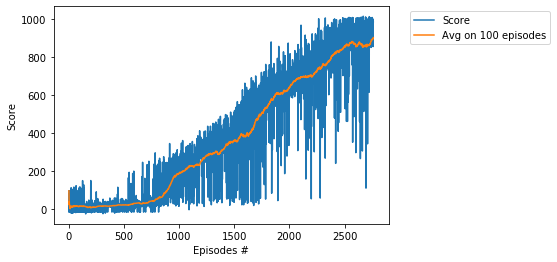

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [12]:
env.close()